# IMAGE PROCESSING - FACE RECOGNITION ATTENDANCE SYSTEM
### Team Members (Roll Numbers):

*   Sarah Biju (MS23090)
*   Tushti Govind (MS23144)
*   Eshita Tandon (MS23163)

### Tools/ Libraries:
 Python, OpenCV, NumPy, Pandas, Scikit-learn, Matplotlib, DeepFace, SQLite3, Joblib

### Dataset:
Labeled Faces in the Wild (LFW)

### Database:
SQLite

### Models/ Techniques:
Facenet, Principal Component Analysis (PCA), Support Vector Machine (SVM)


## Objective 1
- To build a dataset of 15–20 individuals (students) using the LFW dataset.
- To perform exploratory data analysis on number of images, image sizes, and sample visualization.

✅ Total people selected: 20
✅ Dataset saved in data/known_faces/


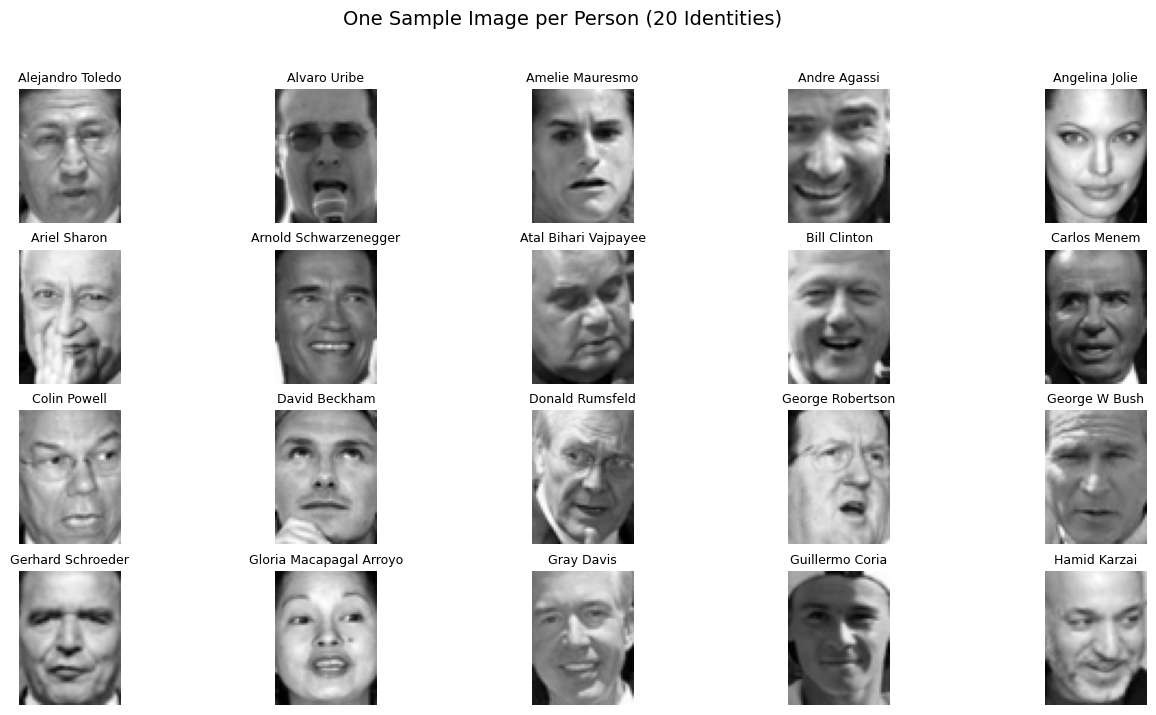


🧍 Showing all images of: Amelie Mauresmo (21 total)


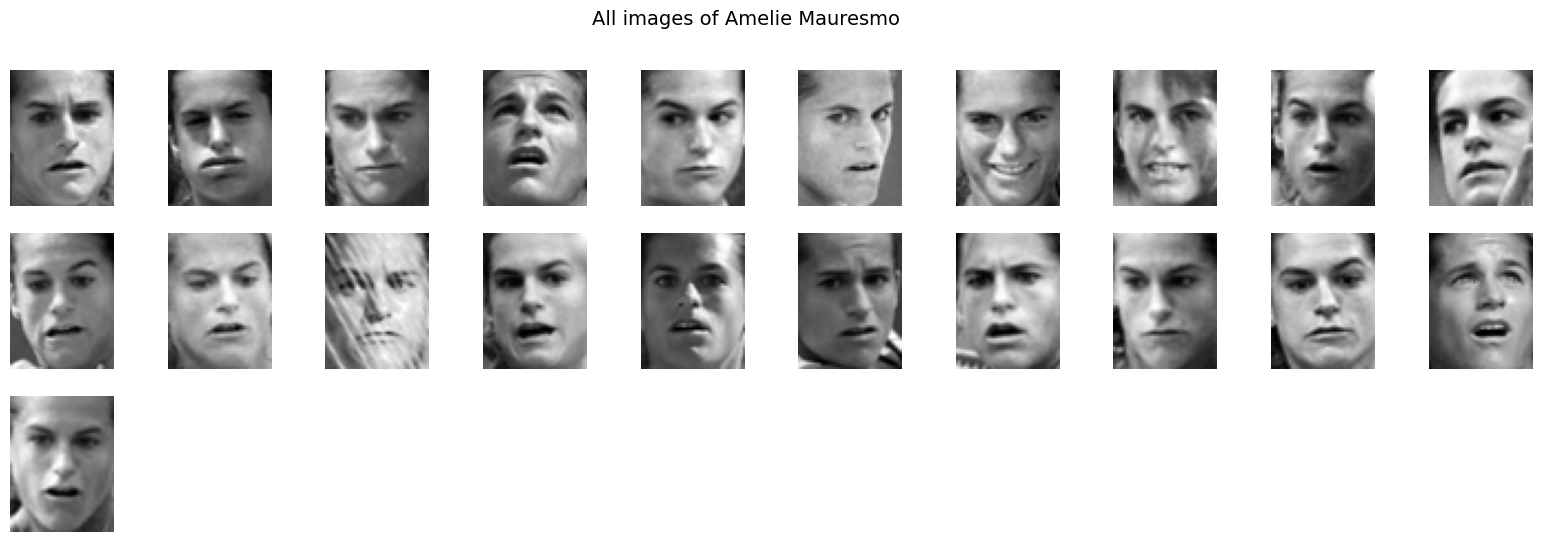

In [ ]:
# =======================================
# LFW Dataset Extraction + Visualization
# =======================================
from sklearn.datasets import fetch_lfw_people
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Fetch LFW dataset (filtering by minimum 20 images/person)
lfw = fetch_lfw_people(min_faces_per_person=20, resize=0.5)
X = lfw.images
y = lfw.target
names = lfw.target_names

# Step 2: Select first 20 identities
num_identities = 20
selected_indices = list(range(min(num_identities, len(names))))
selected_names = [names[i] for i in selected_indices]

print(f"✅ Total people selected: {len(selected_names)}")

# Step 3: Create folders and save up to 50 images per person
os.makedirs("data/known_faces", exist_ok=True)

for idx in selected_indices:
    name = names[idx].replace(" ", "_")
    person_dir = os.path.join("data/known_faces", name)
    os.makedirs(person_dir, exist_ok=True)

    im_idxs = [i for i, t in enumerate(y) if t == idx]
    for j, im_i in enumerate(im_idxs[:50]):
        img = (X[im_i] * 255).astype('uint8')
        img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        fname = os.path.join(person_dir, f"{name}_{j+1}.jpg")
        cv2.imwrite(fname, img_bgr)

print("✅ Dataset saved in data/known_faces/")

# Step 4: Show one sample image per person (overview)
plt.figure(figsize=(16, 8))
for i, idx in enumerate(selected_indices):
    plt.subplot(4, 5, i + 1)
    first_img = X[np.where(y == idx)[0][0]]
    plt.imshow(first_img, cmap='gray')
    plt.title(names[idx], fontsize=9)
    plt.axis('off')
plt.suptitle("One Sample Image per Person (20 Identities)", fontsize=14)
plt.show()

# Step 5: Show all images of one selected person (e.g., the 3rd person)
if len(selected_indices) > 2:
    person_index = selected_indices[2]
    person_name = names[person_index]
    person_images = X[np.where(y == person_index)[0]]
    print(f"\n🧍 Showing all images of: {person_name} ({len(person_images)} total)")
    cols = 10
    rows = int(np.ceil(len(person_images) / cols))
    plt.figure(figsize=(20, rows * 2))
    for i, img in enumerate(person_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.suptitle(f"All images of {person_name}", fontsize=14)
    plt.show()


## Objective 2
- To encode the face images using a pre-trained model (DeepFace).
- To store the face encodings in a SQLite database for easy access.
- To perform dimensionality reduction on the face encodings using PCA.

In [ ]:
# =========================================================
# Database Integration & Feature Analysis (using DeepFace)
# =========================================================

# Step 0: Environment setup
!pip install deepface --quiet
!pip install opencv-python pandas matplotlib scikit-learn --quiet

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU for simplicity

import cv2
import pandas as pd
import numpy as np
from deepface import DeepFace
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import sqlite3
import joblib # Import joblib to save the PCA model

# Step 1: Encode all faces (from LFW dataset)
data_dir = "data/known_faces"
encodings, labels = [], []

print("🔍 Encoding faces from dataset (DeepFace)...")
for person_name in os.listdir(data_dir):
    person_path = os.path.join(data_dir, person_name)
    if not os.path.isdir(person_path):
        continue
    for img_name in os.listdir(person_path):
        img_path = os.path.join(person_path, img_name)
        try:
            embedding = DeepFace.represent(img_path, model_name='Facenet', enforce_detection=False)[0]["embedding"]
            encodings.append(embedding)
            labels.append(person_name)
        except Exception as e:
            print(f"⚠️ Error reading {img_path}: {e}")

print(f"✅ Encoded {len(encodings)} faces from {len(set(labels))} people.")

# Step 2: Create DataFrame
df = pd.DataFrame(encodings)
df["label"] = labels
print("📋 Encoding sample:\n", df.head())

# Save CSV
df.to_csv("lfw_face_encodings.csv", index=False)
print("💾 Saved encodings to lfw_face_encodings.csv")

# Step 3: Store in SQLite database
conn = sqlite3.connect("lfw_faces.db")
df.to_sql("faces_table", conn, if_exists="replace", index=False)
conn.commit()
conn.close()
print("✅ Stored face encodings in lfw_faces.db")

# Step 4: Read back from DB (Optional: for verification)
# conn = sqlite3.connect("lfw_faces.db")
# df_db = pd.read_sql_query("SELECT * FROM faces_table", conn)
# conn.close()
# print(f"📊 Loaded {df_db.shape[0]} rows and {df_db.shape[1]} columns from database.")


# Step 5: PCA (Feature Reduction)
X = df.drop(columns=["label"]).values
pca = PCA(n_components=10)
reduced = pca.fit_transform(X)
variance_ratio = np.round(pca.explained_variance_ratio_ * 100, 2)
print("Explained Variance Ratio (%):", variance_ratio)

# Save PCA model
pca_filename = "pca_model.pkl"
joblib.dump(pca, pca_filename)
print(f"💾 Saved PCA model to {pca_filename}")


# Save reduced dataset
df_reduced = pd.DataFrame(reduced, columns=[f"PC{i+1}" for i in range(10)])
df_reduced["label"] = df["label"] # Use labels from original df
df_reduced.to_csv("lfw_faces_reduced.csv", index=False)
print("💾 Saved PCA-reduced features to lfw_faces_reduced.csv")

# Step 6: Visualizations

# (A) Variance explained
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.title("Variance Explained by PCA Components")
plt.grid(True)
plt.show()

# (B) 2D PCA scatter plot
plt.figure(figsize=(10,6))
unique_labels = df_reduced["label"].unique()
for person in unique_labels:
    data = df_reduced[df_reduced["label"] == person]
    plt.scatter(data["PC1"], data["PC2"], label=person, alpha=0.6)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of LFW Face Encodings")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

print("✅ Day 2 complete — Database & PCA Analysis finished.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.3/128.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.3 MB/s eta 0:00:00
25-10-27 08:49:09 - Directory /root/.deepface has been created
25-10-27 08:49:09 - Directory /root/.deepface/weights has been created
🔍 Encoding faces from dataset (DeepFace)...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /root/.deepface/weights/facenet_weights.h5


25-10-27 08:49:13 - 🔗 facenet_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5 to /root/.deepface/weights/facenet_weights.h5...


100%|██████████| 92.2M/92.2M [00:00<00:00, 247MB/s]


## Objective 3
- To train an SVM classifier on the face encodings to recognize individuals.


📂 Dataset loaded: (692, 11)
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -8.052210 -0.951382 -3.088609 -0.714582 -1.237523 -1.093918 -0.969834   
1 -6.336368 -0.342474 -2.409860  0.141256 -3.658372 -3.005609 -0.534281   
2 -8.122684 -1.559084 -3.721737  0.988810 -2.697117 -2.014705 -0.348043   
3 -7.682950 -1.733473 -2.599768  0.493557 -2.696047 -2.180154  0.899513   
4 -8.494581 -1.236680 -1.997294  0.919488 -1.159521 -1.541535  0.043447   

        PC8       PC9      PC10         label  
0 -1.326493 -2.980027 -0.852965  Ariel_Sharon  
1 -1.513051 -3.444699 -2.694962  Ariel_Sharon  
2 -4.292246 -0.777149 -1.206012  Ariel_Sharon  
3 -3.211562 -3.166166 -1.825110  Ariel_Sharon  
4 -3.444138 -1.692707 -1.286721  Ariel_Sharon  
✅ Train size: (553, 10), Test size: (139, 10)
🧠 Training SVM classifier...
💾 Saved trained SVM model to svm_128D_model.pkl
🎯 Model Accuracy: 96.40%


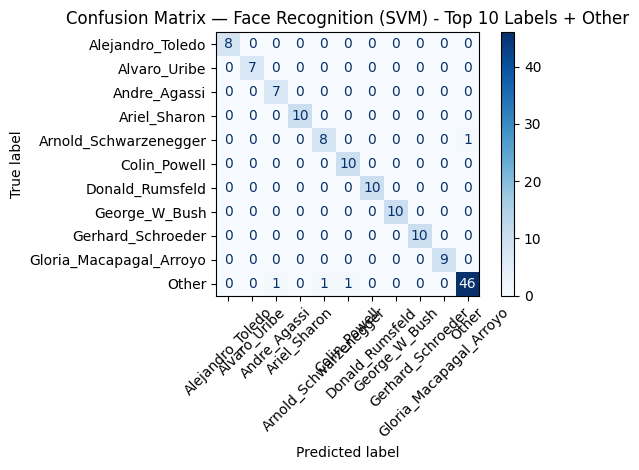

✅ Day 3 complete — Model training, prediction, and evaluation done.


In [ ]:
# =============================================
# Model Training & Prediction (SVM Classifier)
# =============================================

# Step 0: Imports
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib # Import joblib to save the model

# Step 1: Load Encoded Dataset
# You can choose either the full encoding or the PCA-reduced one
df = pd.read_csv("lfw_faces_reduced.csv")  # or "lfw_face_encodings.csv" if you skipped PCA

print("📂 Dataset loaded:", df.shape)
print(df.head())

# Step 2: Prepare Features and Labels
X = df.drop(columns=["label"]).values
y = df["label"].values

# Split into training and testing sets (80 % / 20 %)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"✅ Train size: {X_train.shape}, Test size: {X_test.shape}")

# Step 3: Train SVM Model
print("🧠 Training SVM classifier...")
model = SVC(kernel="linear", probability=True)
model.fit(X_train, y_train)

# Step 3a: Save the trained model
model_filename = "svm_128D_model.pkl" # Naming convention: svm_DimensionsOfFeatures_model.pkl
joblib.dump(model, model_filename)
print(f"💾 Saved trained SVM model to {model_filename}")


# Step 4: Predictions & Accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"🎯 Model Accuracy: {accuracy*100:.2f}%")

# Step 5: Confusion Matrix
# Select top N labels for clearer visualization
top_n = 10
label_counts = pd.Series(y_test).value_counts()
top_labels = label_counts.nlargest(top_n).index.tolist()

# Map labels to 'Other' if not in top_labels
y_test_filtered = [label if label in top_labels else 'Other' for label in y_test]
y_pred_filtered = [label if label in top_labels else 'Other' for label in y_pred]

# Get unique labels from the filtered lists
unique_filtered_labels = sorted(list(set(y_test_filtered + y_pred_filtered)))

cm = confusion_matrix(y_test_filtered, y_pred_filtered, labels=unique_filtered_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_filtered_labels)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title(f"Confusion Matrix — Face Recognition (SVM) - Top {top_n} Labels + Other")
plt.tight_layout()
plt.show()

print("✅ Day 3 complete — Model training, prediction, and evaluation done.")